# Visual search with k-NN
The idea here is to implement a little search engine based on the high-level image representation and k-nearest neighbors.

Let's start by loading the data from npz files 

In [15]:
import importlib; import cours_proj4_funcs; 
importlib.reload(cours_proj4_funcs)
from cours_proj4_funcs import f_read_npzF, f_addIdxFeat, f_fileApp

In [16]:
import numpy as np
import os

X_tr_ini, y_tr_ini, X_data_tr, fnames_tr, y_cat_tr = f_read_npzF(os.path.join('data', 'data_train.npz'))
X_tr_ini1 = f_addIdxFeat(X_tr_ini)

X_va_ini, y_va_ini, X_data_va, fnames_va, y_cat_va = f_read_npzF(os.path.join('data', 'data_valid.npz'))
X_va_ini1 = f_addIdxFeat(X_va_ini)

X_te_ini, y_te_ini, X_data_te, fnames_te, y_cat_te = f_read_npzF(os.path.join('data', 'data_test.npz'))
X_te_ini1 = f_addIdxFeat(X_te_ini)

#### - Fit and tune a k-NN classifier

In [17]:
import numpy as np

k_values = np.concatenate(([1], np.arange(2, 20, 2)), axis=0)
# array([ 1,  2,  4,  6,  8, 10, 12, 14, 16, 18]) #10

X_ini = np.concatenate((X_tr_ini, X_va_ini), axis=0) #280
y_ini = np.concatenate((y_tr_ini, y_va_ini), axis=0) #139

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create k-NN classifier
knn = KNeighborsClassifier( n_neighbors=10 # Set k to 10
                            # Use the simple 'brute' strategy to find
                            # nearest neighbors. It's faster in this case!
                           ,algorithm='brute' )

# Create the pipeline and fit it to training data
knn_pipe = Pipeline([ #('scaler', StandardScaler()), # With standardization
                    ('scaler', None), # trying without standardization!
                    ('knn', knn) 
                    ])

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split

# run_idx will run only one time since the Run several there is no suffling over the splitting
gs_results = []
for run_idx in range(1): #range(5):
    # Split into train/test sets
    X_tr, X_va, y_tr, y_va = train_test_split(X_ini, y_ini, test_size=139, random_state=run_idx, shuffle=False)
    
    # Grid search
    for k in k_values:
        # Fit k-NN model
        knn_pipe.set_params(knn__n_neighbors=k)
        knn_pipe.fit(X_tr, y_tr)

        # Save model and its performance on train/test sets
        gs_results.append({ 'k': k
                            ,'run_idx': run_idx
                            ,'train_accuracy': knn_pipe.score(X_tr, y_tr)
                            ,'test_accuracy': knn_pipe.score(X_va, y_va)
                            })
        
# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
#gs_results.head()

In [20]:
# Group results by alpha value
grouped = gs_results.groupby('k')

# Compute train/test mean scores with std
mean_tr = grouped.train_accuracy.mean()
mean_te = grouped.test_accuracy.mean()
std_tr = grouped.train_accuracy.std()
std_te = grouped.test_accuracy.std()

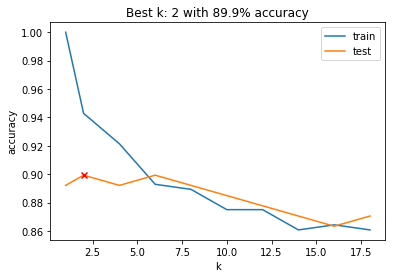

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot mean scores
plt.plot(k_values, mean_tr, label='train')
plt.plot(k_values, mean_te, label='test')

# Add marker for best score
best_k = mean_te.idxmax()
plt.scatter(best_k, mean_te.max(), marker='x', c='red', zorder=10)

# Quantify variance with ±std curves
plt.fill_between(k_values, mean_tr-std_tr, mean_tr+std_tr, alpha=0.2)
plt.fill_between(k_values, mean_te-std_te, mean_te+std_te, alpha=0.2)
plt.title('Best k: {} with {:.1f}% accuracy'.format(best_k, 100*mean_te[best_k]))
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend()
plt.show()

In [22]:
knn_pipe.set_params(knn__n_neighbors=6) #2
knn_pipe.fit(X_tr, y_tr)

test_acc_knn = knn_pipe.score(X_te_ini, y_te_ini)
print("k-NN test accuracy: {}, to save in the file results09.csv".format(test_acc_knn))

# k-NN test accuracy to append into the file 
f_fileApp('data/results09.csv',0,"k-NN", test_acc_knn)

k-NN test accuracy: 0.96, to save in the file results09.csv


#### - Pick an image from the test set and plot its 10 nearest neighbors from the train set

Hint: take a look at the `kneighbors()` method from Scikit-learn k-NN estimators.

Example
How to insert an image:

<img src="https://d7whxh71cqykp.cloudfront.net/uploads/image/data/4250/nearest-neighbors.png" alt="Smiley face" height="80%" width="80%">

Example: A bicycle from the test set and its ten neighbors (with distances)

In [23]:
from sklearn.model_selection import train_test_split

# Split data into train/test sets from Train set only..!
X_tr1, X_te1, y_tr, y_te = train_test_split(X_tr_ini1, y_tr_ini, train_size=220, test_size=60, random_state=0)

In [24]:
idxs_tr, idxs_te = X_tr1[:,0].astype(np.int32), X_te1[:,0].astype(np.int32)

X_tr, X_te = X_tr1[:,1:], X_te1[:,1:]

To look for Neighbours for 'train/van/van-0025.png'


<function matplotlib.pyplot.show(*args, **kw)>

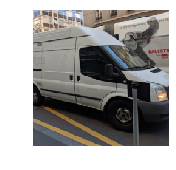

In [25]:
import random

# picking up a random number to show an image
irowImg = random.randint(0, idxs_te.shape[0]-1) 

print("To look for Neighbours for 'train/{}'".format(fnames_tr[idxs_te[irowImg]]))

#%matplotlib inline
#import matplotlib.pyplot as plt

plt.figure(figsize=(2.5,2.5))
plt.imshow(X_data_tr[idxs_te[irowImg]])
plt.axis("off")
plt.show

In [26]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(X_tr)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=10, p=2, radius=1.0)

In [27]:
dist10, neigh10 = neigh.kneighbors(X_te[irowImg, np.newaxis], return_distance=True)

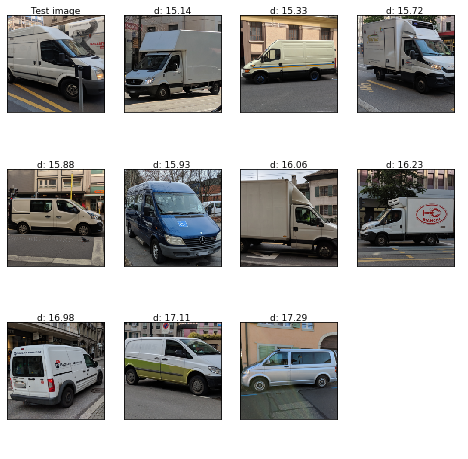

In [28]:

_, axes = plt.subplots(nrows=3, ncols=4, figsize=(8, 8))

axes_flat = axes.flatten()

axes_flat[0].set_title('Test image', size=9, pad=2)
axes_flat[0].imshow(X_data_tr[idxs_te[irowImg]])
axes_flat[0].get_xaxis().set_visible(False)
axes_flat[0].get_yaxis().set_visible(False)


for i, axis in enumerate(axes_flat[1:]): #enumerate(axes.flatten()):
    
    if i>= len(neigh10[0]): #nber of images to show
        axis.axis("off")
        continue
    
    #img = img_batches_tr[ neigh10[0][i] ]
    img = X_data_tr[ idxs_tr[ neigh10[0][i] ] ]
    
    axis.imshow(img)
    
    axis.set_title('d: {:.2f}'.format(dist10[0][i]), size=9, pad=2)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

plt.show()
